<a href="https://colab.research.google.com/github/Sahaswari/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install tensorflow -q
!pip install opendatasets -q

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import time

import opendatasets as od
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
od.download("https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = (224,224)

In [9]:
train_data_dir = "/content/brain-tumor-classification-mri/Training"
test_data_dir = "/content/brain-tumor-classification-mri/Testing"

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset='training',
    validation_split=0.1,
    seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset='validation',
    validation_split=0.1,
    seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE)

Found 2870 files belonging to 4 classes.
Using 2583 files for training.
Found 2870 files belonging to 4 classes.
Using 287 files for validation.
Found 394 files belonging to 4 classes.


In [14]:
types = train_data.class_names
types

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [15]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 224, 224, 3)
(32,)


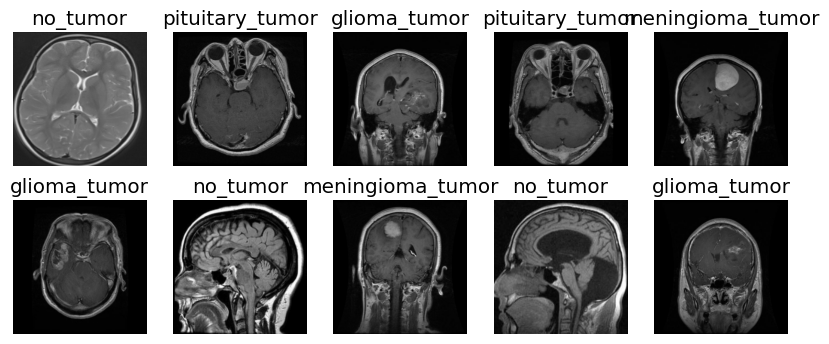

In [17]:
#plot data
plt.figure(figsize=(10,4))
for image, label in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(types[label[i]])
    plt.axis('off')

In [23]:
#data visulaization
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

In [21]:
#Data Prepositing
#Data Normalization
train_data = train_data.map(lambda x, y:(x/255,y))
validation_data = validation_data.map(lambda x, y:(x/255,y))
test_data = test_data.map(lambda x, y:(x/255,y))

In [22]:
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.00410162 0.00410162 0.00410162]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

In [24]:
#Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",input_shape=(224,224,3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ]
)

In [ ]:
#build model Architecture
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))

model.add(tf.keras.layers.Dense(4,activation = 'softmax'))


In [ ]:
model.complie(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])